### 패키지 import
---
필요 library 들여오기

In [150]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 데이터 가져오기 및  초반 세팅
---
데이터를 불러오고 batchsize와 epoch을 정합니다.

In [151]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [152]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 전처리
---
데이터를 학습용과 검증용 및 최종 확인용으로 나누고, 레이블을 붙입니다.\
그 외에 사이즈 수정등의 처리도 진행합니다.

In [153]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [154]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [155]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [187]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [188]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [158]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [159]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [189]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [190]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [191]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 전처리2
---
augmentation을 진행하는데, 비교 할 모델을 위해 augmentation이 사용되지 않는 경우도 만듭니다.

In [163]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_noaug = prepare_for_training(train_ds)
val_ds_noaug = prepare_for_training(val_ds)

In [192]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 시각화
---
augmentation을 적용한 것과 적용하지 않은 것을 각각 시각화해봤습니다.\
처음이 augmentation이 적용된 것이고, 뒤의 것이 적용되지 않은 것입니다.

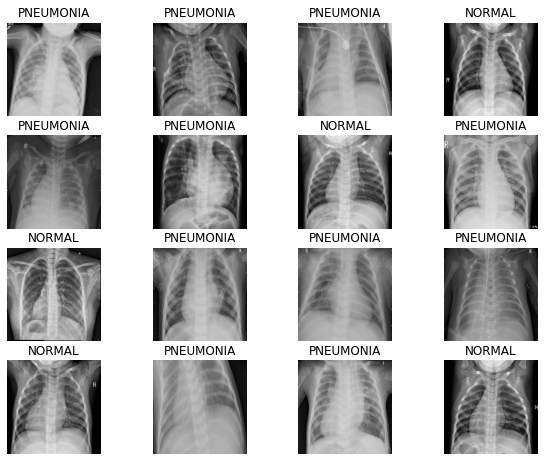

In [193]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

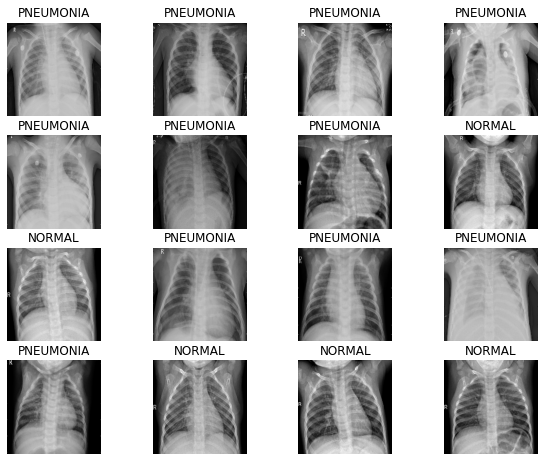

In [166]:
image_batch_noaug, label_batch_noaug = next(iter(train_ds_noaug))
show_batch(image_batch_noaug.numpy(), label_batch_noaug.numpy())

### 모델 생성
---
모델을 생성하는데 dropout을 적용한 것과 적용하지 않은 것을 생성했습니다.\
처음 것이 dropout이 적용된 모델이고, 나중 것이 dropout이 적용되지 않은 모델입니다.

In [167]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [168]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [169]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

dropout이 적용되지 않은 모델

In [170]:
def dense_block_nodrop(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [171]:
def build_model_nodrop():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_nodrop(512),
        dense_block_nodrop(128),
        dense_block_nodrop(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

데이터의 불균형을 해소하기위한 가중치 설정부분입니다.

In [172]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련
---
augmentation을 적용하고 dropout을 적용하지 않은 모델이 첫 번째,\
augmentation을 적용하지 않고 dropout이 적용된 모델이 두 번째,\
augmentation과 dropout을 모두 적용한 모델이 세 번째입니다.

In [199]:
with tf.device('/GPU:0'):
    model_nodrop_aug = build_model_nodrop()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_nodrop_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [200]:
with tf.device('/GPU:0'):
    history_nodrop_aug = model_nodrop_aug.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // (BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // (BATCH_SIZE),
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 73s 236ms/step - loss: 0.3086 - accuracy: 0.8645 - precision: 0.9654 - recall: 0.8472 - val_loss: 0.6738 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1706 - accuracy: 0.9357 - precision: 0.9799 - recall: 0.9332 - val_loss: 0.9783 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 230ms/step - loss: 0.1546 - accuracy: 0.9448 - precision: 0.9807 - recall: 0.9449 - val_loss: 0.1098 - val_accuracy: 0.9731 - val_precision: 0.9717 - val_recall: 0.9921
Epoch 4/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1182 - accuracy: 0.9555 - precision: 0.9893 - recall: 0.9507 - val_loss: 0.9698 - val_accuracy: 0.7337 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 62s 237ms/step - loss: 0.1055 - accura

두 번째

In [197]:
with tf.device('/GPU:0'):
    model_noaug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_noaug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [198]:
with tf.device('/GPU:0'):
    history_noaug = model_noaug.fit(
        train_ds_noaug,
        steps_per_epoch=TRAIN_IMG_COUNT // (BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_ds_noaug,
        validation_steps=VAL_IMG_COUNT // (BATCH_SIZE),
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 73s 237ms/step - loss: 0.5257 - accuracy: 0.7368 - precision: 0.9242 - recall: 0.7067 - val_loss: 0.6423 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 60s 232ms/step - loss: 0.2225 - accuracy: 0.9075 - precision: 0.9776 - recall: 0.8956 - val_loss: 1.0565 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 232ms/step - loss: 0.2100 - accuracy: 0.9270 - precision: 0.9801 - recall: 0.9214 - val_loss: 0.4075 - val_accuracy: 0.7490 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1675 - accuracy: 0.9385 - precision: 0.9836 - recall: 0.9323 - val_loss: 0.0841 - val_accuracy: 0.9721 - val_precision: 0.9986 - val_recall: 0.9634
Epoch 5/25
261/261 [==============================] - 63s 243ms/step - loss: 0.1501 - accura

세 번째

In [194]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [195]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // (BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // (BATCH_SIZE),
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 73s 236ms/step - loss: 0.5512 - accuracy: 0.7090 - precision: 0.9184 - recall: 0.6613 - val_loss: 0.6362 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 63s 241ms/step - loss: 0.2675 - accuracy: 0.8785 - precision: 0.9661 - recall: 0.8679 - val_loss: 1.3639 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 63s 242ms/step - loss: 0.2294 - accuracy: 0.9098 - precision: 0.9765 - recall: 0.9019 - val_loss: 0.6576 - val_accuracy: 0.7510 - val_precision: 0.7468 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 61s 235ms/step - loss: 0.1920 - accuracy: 0.9250 - precision: 0.9816 - recall: 0.9167 - val_loss: 0.1706 - val_accuracy: 0.9288 - val_precision: 0.9929 - val_recall: 0.9097
Epoch 5/25
261/261 [==============================] - 62s 236ms/step - loss: 0.1756 - accura

### 결과 확인
---
그래프를 비교해보았습니다.

#### dropout을 적용 안 한 모델 vs dropout을 적용한 모델 - 두 모델 모두 augmentation은 적용
---
accuracy를 기준으로 봤을 때 두 모델의 진폭이 낮아지므로, 수렴한다고 파악되어집니다.\
다만, recall의 경우에는 수렴한다고 보기 어려운 모습을 보이는 것 같습니다.

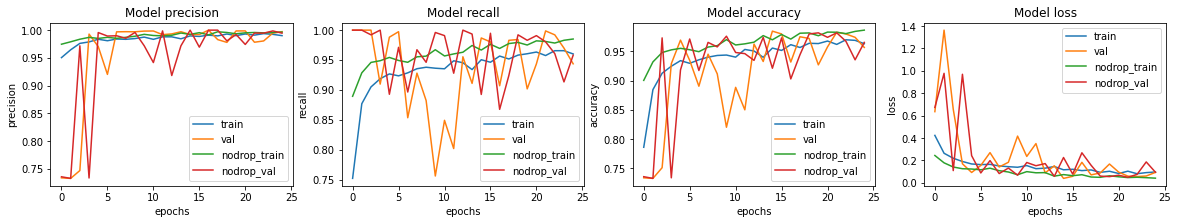

In [206]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_nodrop_aug.history[met])
    ax[i].plot(history_nodrop_aug.history['val_' + met])    
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val', 'nodrop_train', 'nodrop_val'])   

#### augmentatiom을 적용 안 한 모델 vs augmentation을 적용한 모델 - 두 모델 모두 dropout은 적용
---
augmentation을 적용하지 않은 모델의 경우 중간의 peak이 매우 커서 수렴여부가 의심스럽습니다.\
더불어 여전히 recall값의 수렴여부는 판단하기 어렵습니다.

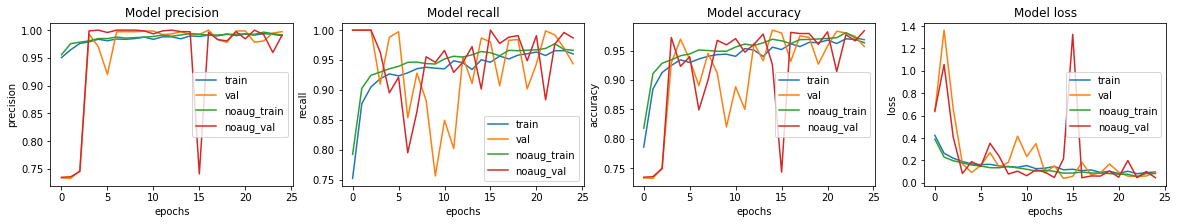

In [205]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_noaug.history[met])
    ax[i].plot(history_noaug.history['val_' + met])    
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val', 'noaug_train', 'noaug_val'])   

### 최종결과(evaluate)
---
augmentation을 적용하고 dropout을 적용하지 않은 모델이 첫 번째로, 0.83의 값을 보였습니다.\
augmentation을 적용하지 않고 dropout이 적용된 모델이 두 번째, 0.77의 값을 보였습니다.\
augmentation과 dropout을 모두 적용한 모델이 세 번째, 0.85의 값을 보였습니다.

In [201]:
loss, accuracy, precision, recall = model_nodrop_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 147ms/step - loss: 0.9473 - accuracy: 0.8317 - precision: 0.7987 - recall: 0.9769
Loss: 0.9473440647125244,
Accuracy: 0.8317307829856873,
Precision: 0.7987421154975891,
Recall: 0.9769230484962463


In [202]:
loss, accuracy, precision, recall = model_noaug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 148ms/step - loss: 1.0505 - accuracy: 0.7772 - precision: 0.7390 - recall: 0.9949
Loss: 1.0504859685897827,
Accuracy: 0.7772436141967773,
Precision: 0.739047646522522,
Recall: 0.9948717951774597


In [196]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 151ms/step - loss: 0.7094 - accuracy: 0.8510 - precision: 0.8221 - recall: 0.9718
Loss: 0.7093735337257385,
Accuracy: 0.8509615659713745,
Precision: 0.8221257925033569,
Recall: 0.971794843673706


### 회고
---
기존 방법에 augmentation을 적용한 모델만이 무사히 0.85이상의 값을 보일 수 있었습니다만,\
종종 0.85이하의 값이 최종결과로 나오곤 하여서, 다른 시도를 해봤지만 그 이상의 값을 얻을 수는 없었습니다.\
시도했던 것은 optimization을 RMSprop, nadam 등으로 변경해 보는 것과 dropout의 숫자를 변경하는 것, epoch값을 증감시켜보는 것이었습니다.\
dropout의 값은 0.4까지는 뚜렷한 변화가 없다가 0.5이상부터 accuracy의 감소를 확인할 수 있었습니다.
모델의 학습속도가 있기에 성능개선의 어려움을 새삼 체감할 수 있던 노드였습니다.